In [43]:
import polars as pl
import matplotlib.pyplot as plt
import blitzbeaver as bb
from blitzbeaver.tracking_graph import (
    MaterializedTrackerFrame,
    MaterializedTrackingChain,
    TrackerFrameDiagnostics,
    RecordSchema,
)
from blitzbeaver.literals import ID
import random
from Levenshtein import distance
from os import walk

In [44]:
csv_path = "../../aptihramy/data/csv_cleaned"
beaver_folder_path = "../beaver_files"

In [45]:
dataframes_35_45 = [
    pl.read_csv(f"{csv_path}/{year}.csv", infer_schema_length=10000)
    for year in range(1835, 1845 + 1)
]

dataframes_60_70 = [
    pl.read_csv(f"{csv_path}/{year}.csv", infer_schema_length=10000)
    for year in range(1860, 1870 + 1)
]

dataframes_87_97 = [
    pl.read_csv(f"{csv_path}/{year}.csv", infer_schema_length=10000)
    for year in range(1887, 1897 + 1)
]

In [46]:
record_schema_base = bb.RecordSchema(
    [
        bb.FieldSchema("nom_rue", bb.ElementType.String),
        bb.FieldSchema("chef_prenom", bb.ElementType.String),
        bb.FieldSchema("chef_nom", bb.ElementType.String),
        bb.FieldSchema("chef_origine", bb.ElementType.String),
        bb.FieldSchema("epouse_nom", bb.ElementType.String),
        bb.FieldSchema("chef_vocation", bb.ElementType.String),
        bb.FieldSchema("enfants_chez_parents_prenom", bb.ElementType.MultiStrings),
    ]
)

In [47]:
record_schema_normalized = bb.RecordSchema(
    [
        bb.FieldSchema("nom_rue_norm", bb.ElementType.String),
        bb.FieldSchema("chef_prenom_norm", bb.ElementType.String),
        bb.FieldSchema("chef_nom_norm", bb.ElementType.String),
        bb.FieldSchema("chef_origine_norm", bb.ElementType.String),
        bb.FieldSchema("epouse_nom_norm", bb.ElementType.String),
        bb.FieldSchema("chef_vocation_norm", bb.ElementType.String),
        bb.FieldSchema("enfants_chez_parents_prenom", bb.ElementType.MultiStrings),
    ]
)

In [48]:
distance_metric_lv_opti = bb.DistanceMetricConfig(
    metric="lv_opti", caching_threshold=4, use_sigmoid=False
)
distance_metric_edit = bb.DistanceMetricConfig(
    metric="lv_edit",
    caching_threshold=4,
    use_sigmoid=False,
    lv_edit_weights=[0.2, 0.5, 0.5],
)
distance_metric_substring = bb.DistanceMetricConfig(
    metric="lv_substring",
    caching_threshold=4,
    use_sigmoid=False,
    lv_substring_weight=0.8,
)
distance_metric_multiword = bb.DistanceMetricConfig(
    metric="lv_multiword",
    caching_threshold=4,
    use_sigmoid=False,
    lv_multiword_separator=" ",
)

In [49]:
record_scorer_average = bb.RecordScorerConfig(
    record_scorer="average",
    weights=None,
    min_weight_ratio=None,
)

record_scorer_base_weight_1 = bb.RecordScorerConfig(
    record_scorer="weighted-average",
    weights=[
        0.2,
        0.25,
        0.25,
        0.25,
        0.15,
        0.2,
        0.1,
    ],
    min_weight_ratio=0.5,
)

record_scorer_base_weight_2 = bb.RecordScorerConfig(
    record_scorer="weighted-average",
    weights=[
        0.15,
        0.25,
        0.25,
        0.25,
        0.1,
        0.2,
        0.1,
    ],
    min_weight_ratio=0.8,
)

In [50]:
resolver_config = bb.ResolverConfig(
    resolving_strategy="best-match",
)

In [51]:
brute_force_memory_config = bb.MemoryConfig(memory_strategy="bruteforce")
most_frequent_memory_config = bb.MemoryConfig(memory_strategy="mostfrequent")
median_memory_config = bb.MemoryConfig(memory_strategy="median")
ls_bruteforce_memory_config = bb.MemoryConfig(memory_strategy="ls-bruteforce")
ls_mostfrequent_memory_config = bb.MemoryConfig(memory_strategy="ls-mostfrequent")
ls_median_memory_config = bb.MemoryConfig(memory_strategy="ls-median")
mw_mostfrequent_memory_config = bb.MemoryConfig(memory_strategy="mw-mostfrequent")
mw_median_memory_config = bb.MemoryConfig(memory_strategy="mw-median")


memory_configs = [
    brute_force_memory_config,
    most_frequent_memory_config,
    median_memory_config,
    ls_bruteforce_memory_config,
    ls_mostfrequent_memory_config,
    ls_median_memory_config,
    mw_mostfrequent_memory_config,
    mw_median_memory_config,
]

multi_memory_lv_opti_config = bb.MemoryConfig(
    memory_strategy="mw-median",
    multiword_threshold_match=0.6,
    multiword_distance_metric=distance_metric_lv_opti,
)

multi_memory_substring_config = bb.MemoryConfig(
    memory_strategy="mw-median",
    multiword_threshold_match=0.6,
    multiword_distance_metric=distance_metric_substring,
)

multi_memory_multiword_config = bb.MemoryConfig(
    memory_strategy="mw-median",
    multiword_threshold_match=0.6,
    multiword_distance_metric=distance_metric_multiword,
)

multi_memory_configs = [
    multi_memory_lv_opti_config,
    multi_memory_substring_config,
    multi_memory_multiword_config,
]

In [52]:
base_config_03 = bb.config(
    record_schema=record_schema_base,
    distance_metric_config=distance_metric_lv_opti,
    record_scorer_config=record_scorer_average,
    resolver_config=resolver_config,
    memory_config=median_memory_config,
    multistring_memory_config=multi_memory_lv_opti_config,
    interest_threshold=0.3,
    limit_no_match_streak=5,
    num_threads=12,
)

base_config_04 = bb.config(
    record_schema=record_schema_base,
    distance_metric_config=distance_metric_lv_opti,
    record_scorer_config=record_scorer_average,
    resolver_config=resolver_config,
    memory_config=median_memory_config,
    multistring_memory_config=multi_memory_lv_opti_config,
    interest_threshold=0.4,
    limit_no_match_streak=5,
    num_threads=12,
)

base_config_05 = bb.config(
    record_schema=record_schema_base,
    distance_metric_config=distance_metric_lv_opti,
    record_scorer_config=record_scorer_average,
    resolver_config=resolver_config,
    memory_config=median_memory_config,
    multistring_memory_config=multi_memory_lv_opti_config,
    interest_threshold=0.5,
    limit_no_match_streak=5,
    num_threads=12,
)

base_config_06 = bb.config(
    record_schema=record_schema_base,
    distance_metric_config=distance_metric_lv_opti,
    record_scorer_config=record_scorer_average,
    resolver_config=resolver_config,
    memory_config=median_memory_config,
    multistring_memory_config=multi_memory_lv_opti_config,
    interest_threshold=0.6,
    limit_no_match_streak=5,
    num_threads=12,
)

normalized_config = bb.config(
    record_schema=record_schema_normalized,
    distance_metric_config=distance_metric_lv_opti,
    record_scorer_config=record_scorer_average,
    resolver_config=resolver_config,
    memory_config=median_memory_config,
    multistring_memory_config=multi_memory_lv_opti_config,
    interest_threshold=0.6,
    limit_no_match_streak=5,
    num_threads=12,
)

low_interest_config = bb.config(
    record_schema=record_schema_base,
    distance_metric_config=distance_metric_lv_opti,
    record_scorer_config=record_scorer_average,
    resolver_config=resolver_config,
    memory_config=median_memory_config,
    multistring_memory_config=multi_memory_lv_opti_config,
    interest_threshold=0.2,
    limit_no_match_streak=5,
    num_threads=12,
)

base_weighted_config = bb.config(
    record_schema=record_schema_base,
    distance_metric_config=distance_metric_lv_opti,
    record_scorer_config=record_scorer_base_weight_2,
    resolver_config=resolver_config,
    memory_config=median_memory_config,
    multistring_memory_config=multi_memory_lv_opti_config,
    interest_threshold=0.4,
    limit_no_match_streak=5,
    num_threads=12,
)

base_edit_config = bb.config(
    record_schema=record_schema_base,
    distance_metric_config=distance_metric_edit,
    record_scorer_config=record_scorer_average,
    resolver_config=resolver_config,
    memory_config=median_memory_config,
    multistring_memory_config=multi_memory_lv_opti_config,
    interest_threshold=0.4,
    limit_no_match_streak=5,
    num_threads=12,
)

base_substring_config = bb.config(
    record_schema=record_schema_base,
    distance_metric_config=distance_metric_substring,
    record_scorer_config=record_scorer_average,
    resolver_config=resolver_config,
    memory_config=median_memory_config,
    multistring_memory_config=multi_memory_lv_opti_config,
    interest_threshold=0.4,
    limit_no_match_streak=5,
    num_threads=12,
)

base_multiword_metric_config = bb.config(
    record_schema=record_schema_base,
    distance_metric_config=distance_metric_multiword,
    record_scorer_config=record_scorer_average,
    resolver_config=resolver_config,
    memory_config=median_memory_config,
    multistring_memory_config=multi_memory_lv_opti_config,
    interest_threshold=0.4,
    limit_no_match_streak=5,
    num_threads=12,
)

base_bruteforce_config = bb.config(
    record_schema=record_schema_base,
    distance_metric_config=distance_metric_lv_opti,
    record_scorer_config=record_scorer_average,
    resolver_config=resolver_config,
    memory_config=ls_bruteforce_memory_config,
    multistring_memory_config=multi_memory_lv_opti_config,
    interest_threshold=0.4,
    limit_no_match_streak=5,
    num_threads=12,
)


base_most_frequent_memory = bb.config(
    record_schema=record_schema_base,
    distance_metric_config=distance_metric_lv_opti,
    record_scorer_config=record_scorer_average,
)

In [53]:
def clean_children(dataframes: pl.DataFrame) -> pl.DataFrame:
    for i in range(len(dataframes)):
        df = dataframes[i]
        dataframes[i] = df.with_columns(
            df["enfants_chez_parents_prenom"]
            .str.split("|")
            .list.eval(pl.element().filter(pl.element() != ""))
            .alias("enfants_chez_parents_prenom")
        )


def compute_and_save(
    config: bb.TrackingConfig,
    record_schema: bb.RecordSchema,
    dataframes: list[pl.DataFrame],
    filepath: str,
) -> bb.TrackingGraph:
    path_graph = f"{beaver_folder_path}/{filepath}"

    clean_children(dataframes)

    graph = bb.execute_tracking(config, record_schema, dataframes, "debug")
    bb.save_beaver(path_graph, graph)
    return graph

In [54]:
dataframes = dataframes_60_70
record_schema = record_schema_base
nb_of_years = 11

In [55]:
# graph = compute_and_save(base_config_06, record_schema, dataframes, "test.beaver")

In [56]:
def aggregate_distance_averages(avgs: list[list[float]], nb_features: int):
    agg = [0] * nb_features

    for avg in avgs:

        for i, val in enumerate(avg):
            agg[i] += val

    return [v / len(avgs) for v in agg]


def avg_distance_metrics(
    graph: bb.TrackingGraph,
    dataframes: list[pl.DataFrame],
    record_schema: RecordSchema,
    id: ID,
) -> list[float] | None:
    nb_features = len(record_schema.fields)
    tracker_diag = graph.diagnostics.get_tracker(id)

    if tracker_diag is None:
        return None

    materialized = graph.materialize_tracking_chain(id, dataframes, record_schema, None)

    avg = [0] * nb_features
    counts = [0] * nb_features

    frame_to_record = {
        m.frame_idx: m.record_idx for m in materialized.matched_frames[1:]
    }

    if len(frame_to_record) == 0:
        return None

    for frame in tracker_diag.frames:
        record_idx = frame_to_record.get(frame.frame_idx)
        if record_idx is None:
            continue

        for record in frame.records:
            if record.record_idx != record_idx:
                continue

            for i, distance in enumerate(record.distances):
                if distance is not None:
                    avg[i] += distance
                    counts[i] += 1
            break

    ret = []
    for i, v in enumerate(avg):
        count = counts[i]
        if count == 0:
            count = 1
        ret.append(v / count)

    return ret


def print_column_scores(
    graph: bb.TrackingGraph, dataframes: list[pl.DataFrame], record_schema: RecordSchema
):
    print("Column scores:")
    avgs = [
        avg_distance_metrics(graph, dataframes, record_schema, id)
        for id in graph.trackers_ids
    ]

    agg_avgs = aggregate_distance_averages(
        [a for a in avgs if a is not None], len(record_schema.fields)
    )
    zipped = list(zip(record_schema.fields, agg_avgs))
    for schema, avg in zipped:
        print(f"{schema.name}: {avg}")

In [57]:
path = f"{beaver_folder_path}/base_config_35_45_06.beaver"
graph = bb.read_beaver(path)
# id = 17604157367110001615
# tracker_diag = graph.diagnostics.get_tracker(id)
# materialized = graph.materialize_tracking_chain(id, dataframes, record_schema, None)


# print(avg_metrics(graph, dataframes, record_schema, id))
# print()
print_column_scores(graph, dataframes, record_schema)

Column scores:
nom_rue: 0.6339294095052341
chef_prenom: 0.8380505890342331
chef_nom: 0.8578063419864067
chef_origine: 0.818329593512926
epouse_nom: 0.7089898900049999
chef_vocation: 0.676168282459501
enfants_chez_parents_prenom: 0.46652083551576795


In [ ]:
def aggregate_histograms(histograms: list[list[int]]) -> list[int]:
    """
    Aggregates a list of histograms into a single histogram.
    """
    max_len = max([len(h) for h in histograms])
    result = [0] * max_len
    for h in histograms:
        for i, v in enumerate(h):
            result[i] += v
    return result


def get_start_end_years(
    graph: bb.TrackingGraph,
    dataframes: list[pl.DataFrame],
    record_schema: RecordSchema,
    nb_of_years: int,
) -> tuple[list[int], list[int]]:

    start_years = [0] * nb_of_years
    end_years = [0] * nb_of_years
    for id in graph.trackers_ids:
        materialized = graph.materialize_tracking_chain(id, dataframes, record_schema)
        start_years[materialized.matched_frames[0].frame_idx] += 1
        end_years[materialized.matched_frames[-1].frame_idx] += 1

    return start_years, end_years


def summary_graph(graph: bb.TrackingGraph, show_graphs: bool):

    # compute the sum of the histograms for all frames
    histogram_records = aggregate_histograms(
        [
            resolving.histogram_record_matchs
            for resolving in graph.diagnostics.resolvings
        ]
    )
    # do not show beyond 10 elements as the counts are very low
    histogram_records = histogram_records
    histogram_trackers = aggregate_histograms(
        [
            resolving.histogram_tracker_matchs
            for resolving in graph.diagnostics.resolvings
        ]
    )
    histogram_trackers = histogram_trackers

    chain_metrics = bb.evaluate_tracking_chain_length(graph._raw)
    graph_metrics = bb.evaluate_tracking_graph_properties(graph._raw)

    start_years, end_years = get_start_end_years(
        graph, dataframes, record_schema, nb_of_years
    )

    records_match_ratios = graph_metrics.records_match_ratios[1:]
    trackers_match_ratios = graph_metrics.trackers_match_ratios[1:-1]
    avg_records_match = sum(records_match_ratios) / len(records_match_ratios)
    avg_trackers_match = sum(trackers_match_ratios) / len(trackers_match_ratios)

    per_divergence = sum(histogram_trackers[2:]) / sum(histogram_trackers[1:])
    per_conflict = sum(histogram_records[2:]) / sum(histogram_records[1:])

    # total number of trackers created
    print(f"Number of chains: {len(graph.trackers_ids)}")
    # average percentage of records that have been match with an existing tracker
    print(f"Percentage of matching records: {avg_records_match*100:.2f}%")
    # average percentage of trackers that have match with a record of the current frame
    print(f"Percentage of matching trackers: {avg_trackers_match*100:.2f}%")
    # number of times a tracker matched with more that one record
    # divided by the number of times a tracker matched with a record
    print(f"Percentage of divergences: {per_divergence*100:.2f}%")
    # number of times a record matched with multiple trackers
    # divided by the number of times a record matched with a tracker
    print(f"Percentage of conflicts: {per_conflict*100:.2f}%")

    print(chain_metrics.histogram[1:])

    if not show_graphs:
        return

    plt.bar(range(1, len(chain_metrics.histogram)), chain_metrics.histogram[1:])
    plt.title("Histogram of tracking chain lengths")
    plt.show()

    plt.bar(range(len(start_years)), start_years)
    plt.title("Histogram of trackers starting years")
    plt.show()

    plt.bar(range(len(end_years)), end_years)
    plt.title("Histogram of trackers ending years")
    plt.show()

    plt.bar(range(len(histogram_records)), histogram_records)
    plt.title("Histogram of # matchs per record")
    plt.show()

    plt.bar(range(len(histogram_trackers)), histogram_trackers)
    plt.title("Histogram of # matchs per tracker")
    plt.show()

../beaver_files/base_config_35_45_03.beaver
Number of chains: 7312
Percentage of matching records: 91.72%
Percentage of matching trackers: 95.85%
Percentage of divergences: 95.43%
Percentage of conflicts: 97.18%
[2174, 464, 297, 214, 215, 240, 267, 332, 409, 672, 2028]


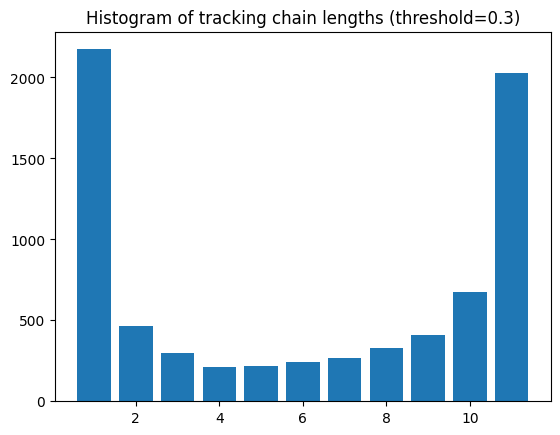

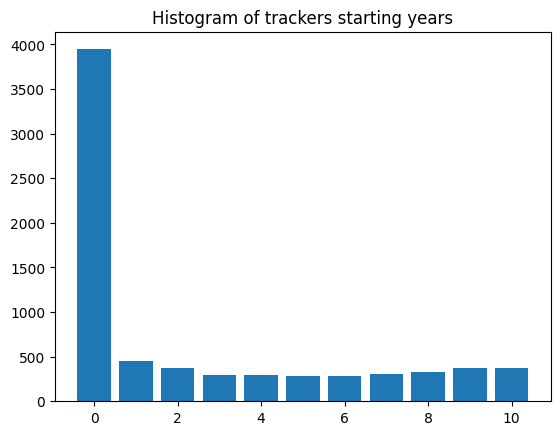

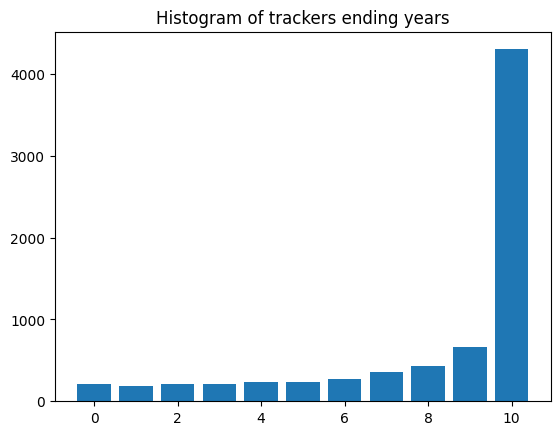

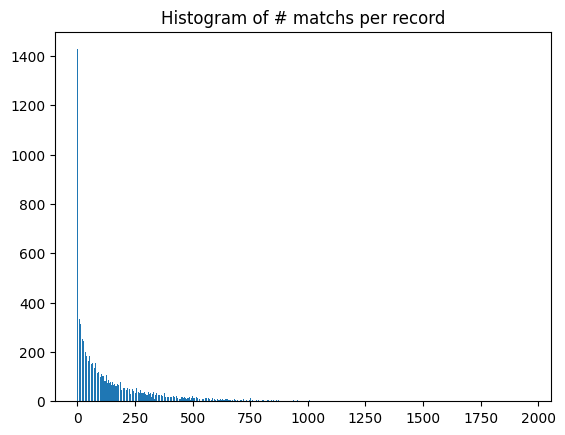

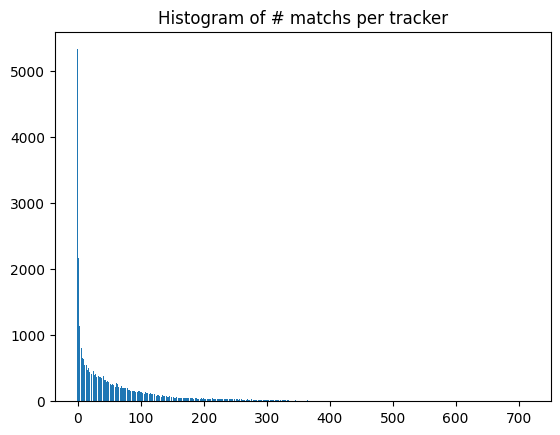


Column scores:
nom_rue: 0.5272642087832174
chef_prenom: 0.6846452815604605
chef_nom: 0.7051683424367928
chef_origine: 0.6608813720833758
epouse_nom: 0.545944778961486
chef_vocation: 0.5516615224834223
enfants_chez_parents_prenom: 0.386797864948482

../beaver_files/base_config_35_45_06.beaver
Number of chains: 23738
Percentage of matching records: 51.29%
Percentage of matching trackers: 77.28%
Percentage of divergences: 5.33%
Percentage of conflicts: 19.43%
[17416, 2424, 1011, 641, 465, 413, 349, 328, 255, 224, 212]


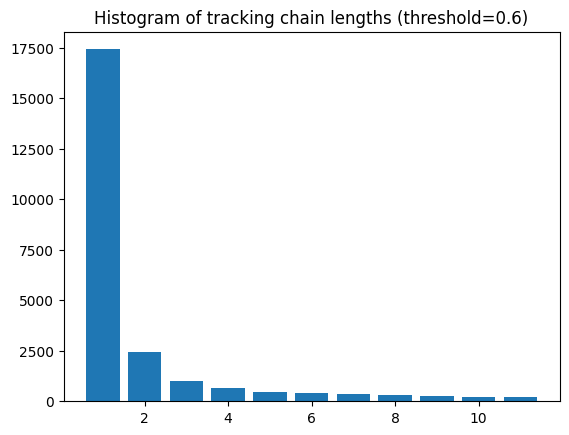

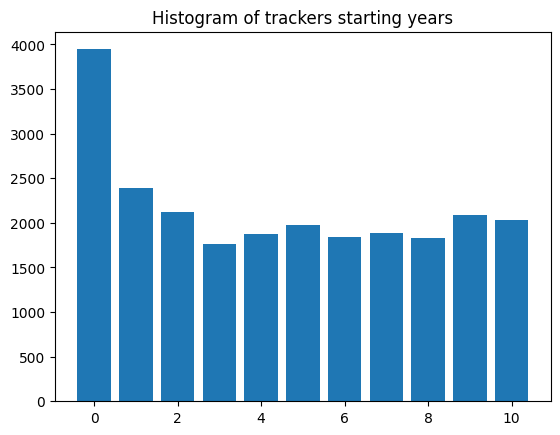

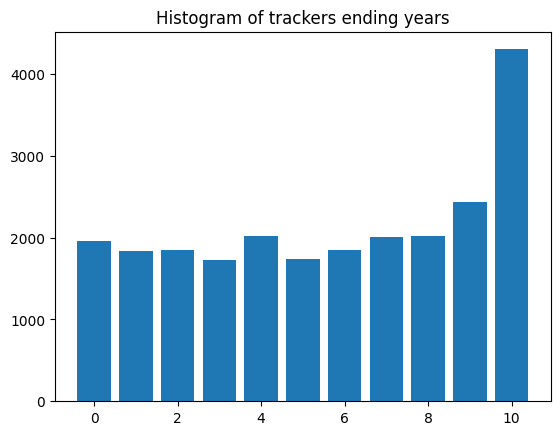

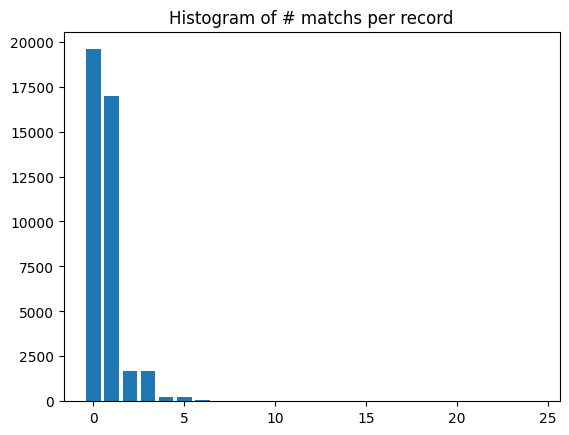

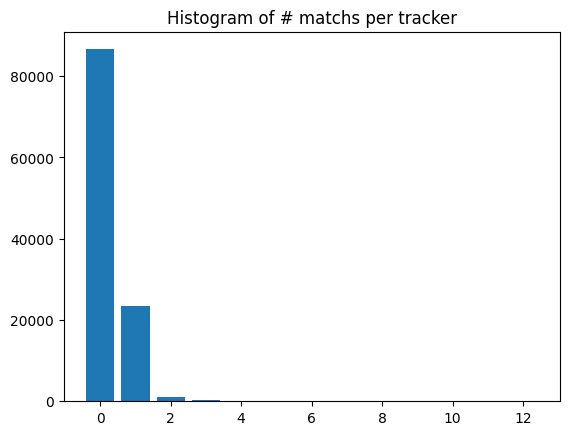


Column scores:
nom_rue: 0.6339294095052341
chef_prenom: 0.8380505890342331
chef_nom: 0.8578063419864067
chef_origine: 0.818329593512926
epouse_nom: 0.7089898900049999
chef_vocation: 0.676168282459501
enfants_chez_parents_prenom: 0.46652083551576795



In [ ]:
def show_stats(path: str):
    print(path)
    graph = bb.read_beaver(path)
    summary_graph(graph, True)
    print()
    print_column_scores(graph, dataframes, record_schema)
    print()


# path = f"{beaver_folder_path}/base_substring_35_45_08.beaver"
# show_stats(path)

# path = f"{beaver_folder_path}/base_substring_35_45_05.beaver"
# show_stats(path)

path = f"{beaver_folder_path}/base_config_35_45_03.beaver"
show_stats(path, "Histogram of tracking chain lengths (threshold=0.3)")

path = f"{beaver_folder_path}/base_config_35_45_06.beaver"
show_stats(path, "Histogram of tracking chain lengths (threshold=0.6)")

# path = f"{beaver_folder_path}/test.beaver"
# show_stats(path)

# path = f"{beaver_folder_path}/weighted_config1_35_45_05.beaver"
# show_stats(path)

# path = f"{beaver_folder_path}/weighted_config2_35_45_06.beaver"
# show_stats(path)

In [60]:
def find_chain_with_length(
    graph: bb.TrackingGraph, start_idx: int, length: int
) -> None | int:
    idx = start_idx
    while idx < len(graph.trackers_ids):
        tracker_id = graph.trackers_ids[idx]
        chain = graph._raw.get_tracking_chain(tracker_id)
        if len(chain) >= length:
            return tracker_id
        idx += 1
    return None


def take_n_random_ids(n: int, graph: bb.TrackingGraph, min_length: int) -> list[int]:
    # Filter only tracker IDs with chain length >= min_length
    valid_ids = [
        tracker_id
        for tracker_id in graph.trackers_ids
        if len(graph._raw.get_tracking_chain(tracker_id)) >= min_length
    ]

    # Adjust n if there are fewer valid IDs than requested
    n = min(n, len(valid_ids))

    return random.sample(valid_ids, n)


def print_verify_df(chain: MaterializedTrackingChain):
    df = chain.as_dataframe().drop("frame_idx").drop("enfants_chez_parents_prenom")
    results = []
    for col in df.columns:
        results.append(verify_column(df[col]))
        print(f"{col}: {verify_column(df[col])}")
    return results


def verify_df(chain: MaterializedTrackingChain):
    df = chain.as_dataframe().drop("frame_idx").drop("enfants_chez_parents_prenom")
    results = []
    for col in df.columns:
        results.append(verify_column(df[col]))
    return results


def print_aggregate_verifiers(l: list[list[float]], fields: list[str]) -> list[float]:
    results = [0] * len(l[0])
    for values in l:
        for i, v in enumerate(values):
            results[i] += v

    print("Aggregated verifiers:")
    norm = [v / len(l) for v in results]
    for i, r in enumerate(norm):
        print(f"{fields[i]}: {r}")
    return norm


def aggregate_verifiers(l: list[list[float]]) -> list[float]:
    results = [0] * len(l[0])
    for values in l:
        for i, v in enumerate(values):
            results[i] += v

    return [v / len(l) for v in results]


def verify_column(l: list[str]) -> float:
    ratios = 0
    for i, value in enumerate(l[:-1]):
        next = l[i + 1]
        max_len = max(len(value), len(next))
        ratios += 1 - distance(value, next) / max_len
    return ratios / (len(l) - 1)

In [61]:
path = f"{beaver_folder_path}/base_config_35_45_06.beaver"
graph = bb.read_beaver(path)
print_column_scores(graph, dataframes, record_schema)
summary_graph(graph, False)

Column scores:
nom_rue: 0.6339294095052341
chef_prenom: 0.8380505890342331
chef_nom: 0.8578063419864067
chef_origine: 0.818329593512926
epouse_nom: 0.7089898900049999
chef_vocation: 0.676168282459501
enfants_chez_parents_prenom: 0.46652083551576795


TypeError: summary_graph() missing 1 required positional argument: 'title'

In [ ]:
w = walk("../beaver_files")
dropped_cols = ["frame_idx", "enfants_chez_parents_prenom"]
filenames = []
for dirpath, dirnames, fs in w:
    filenames.extend(fs)

for filename in filenames:
    path = f"{beaver_folder_path}/{filename}"
    graph_read = bb.read_beaver(path)

    schema = record_schema_base
    if filename == "normalized_base_config.beaver":
        schema = record_schema_normalized

    print(filename)
    print()
    summary_graph(graph_read, False)
    print()
    print_column_scores(graph_read, dataframes, schema)
    print()

base_config_35_45_03.beaver

Number of chains: 7312
Percentage of matching records: 91.72%
Percentage of matching trackers: 95.85%
Percentage of divergences: 95.43%
Percentage of conflicts: 97.18%
[2174, 464, 297, 214, 215, 240, 267, 332, 409, 672, 2028]

Column scores:
nom_rue: 0.5272642087832174
chef_prenom: 0.6846452815604605
chef_nom: 0.7051683424367928
chef_origine: 0.6608813720833758
epouse_nom: 0.545944778961486
chef_vocation: 0.5516615224834223
enfants_chez_parents_prenom: 0.386797864948482

weighted_config1_35_45_05.beaver

Number of chains: 6710
Percentage of matching records: 93.19%
Percentage of matching trackers: 94.61%
Percentage of divergences: 93.24%
Percentage of conflicts: 94.56%
[993, 602, 444, 357, 330, 344, 331, 353, 510, 710, 1736]

Column scores:
nom_rue: 0.5096830898657982
chef_prenom: 0.6941274054176331
chef_nom: 0.7131542966905208
chef_origine: 0.6687469161143617
epouse_nom: 0.5511422759148561
chef_vocation: 0.5406271100700467
enfants_chez_parents_prenom: 0.38

In [ ]:
def find_chain_with_length(
    graph: bb.TrackingGraph, start_idx: int, length: int
) -> None | int:
    idx = start_idx
    while idx < len(graph.trackers_ids):
        tracker_id = graph.trackers_ids[idx]
        chain = graph._raw.get_tracking_chain(tracker_id)
        if len(chain) >= length:
            return tracker_id
        idx += 1
    return None


def take_n_random_ids(n: int, graph: bb.TrackingGraph, min_length: int) -> list[int]:
    # Filter only tracker IDs with chain length >= min_length
    valid_ids = [
        tracker_id
        for tracker_id in graph.trackers_ids
        if len(graph._raw.get_tracking_chain(tracker_id)) >= min_length
    ]

    # Adjust n if there are fewer valid IDs than requested
    n = min(n, len(valid_ids))

    return random.sample(valid_ids, n)


def print_verify_df(chain: MaterializedTrackingChain):
    df = chain.as_dataframe().drop("frame_idx").drop("enfants_chez_parents_prenom")
    results = []
    for col in df.columns:
        results.append(verify_column(df[col]))
        print(f"{col}: {verify_column(df[col])}")
    return results


def verify_df(chain: MaterializedTrackingChain):
    df = chain.as_dataframe().drop("frame_idx").drop("enfants_chez_parents_prenom")
    results = []
    for col in df.columns:
        results.append(verify_column(df[col]))
    return results


def print_aggregate_verifiers(l: list[list[float]], fields: list[str]) -> list[float]:
    agg = aggregate_verifiers(l)
    for i, r in enumerate(agg):
        print(f"{fields[i]}: {r}")


def aggregate_verifiers(l: list[list[float]]) -> list[float]:
    results = [0] * len(l[0])
    for values in l:
        for i, v in enumerate(values):
            results[i] += v

    return [v / len(l) for v in results]


def verify_column(l: list[str]) -> float:
    ratios = 0
    for i, value in enumerate(l[:-1]):
        next = l[i + 1]
        max_len = max(len(value), len(next))
        ratios += 1 - distance(value, next) / max_len
    return ratios / (len(l) - 1)

In [ ]:
def print_verify_n_samples(
    tracking_graph: bb.TrackingGraph,
    schema: RecordSchema,
    nb_samples: int,
    min_length: int,
):
    r = verify_n_samples(tracking_graph, schema, nb_samples, min_length)
    fields = []
    for f in schema.fields:
        if f.name in dropped_cols:
            continue
        fields.append(f.name)
    print_aggregate_verifiers(r, fields)
    

def verify_n_samples(
    tracking_graph: bb.TrackingGraph,
    schema: RecordSchema,
    nb_samples: int,
    min_length: int,
)-> list[list[float]]:
    ids = take_n_random_ids(nb_samples, tracking_graph, min_length)
    a = []

    for id in ids:
        chain = tracking_graph.materialize_tracking_chain(
            id, dataframes, schema, normalized_dataframes=None
        )
        df = chain.as_dataframe().drop("frame_idx").drop("enfants_chez_parents_prenom")
        a.append([verify_column(df[col]) for col in df.columns])
        
    return a


def manual_verifying(
    tracking_graph: bb.TrackingGraph,
    schema: RecordSchema,
    nb_samples: int,
    min_length: int,
):
    ids = take_n_random_ids(nb_samples, tracking_graph, min_length)
    a = []

    for id in ids:
        chain = tracking_graph.materialize_tracking_chain(
            id, dataframes, schema, normalized_dataframes=None
        )
        df = chain.as_dataframe().drop("frame_idx").drop("enfants_chez_parents_prenom")
        a.append([verify_column(df[col]) for col in df.columns])
        print_verify_df(chain)
        print()
        print(chain.as_dataframe())

    print_column_scores(tracking_graph, dataframes, schema)
    print()
    fields = []
    for f in schema.fields:
        if f.name in dropped_cols:
            continue
        fields.append(f.name)
    print_aggregate_verifiers(a, fields)


file_path = "test.beaver"
record_schema = record_schema_base
path = f"{beaver_folder_path}/{file_path}"
graph = bb.read_beaver(path)
# manual_verifying(graph, record_schema, 10, 10)
verify_n_samples(graph, record_schema, 1000, 10)
print()


file_path = "weighted_config2_35_45_06.beaver"
record_schema = record_schema_base
path = f"{beaver_folder_path}/{file_path}"
graph = bb.read_beaver(path)
# manual_verifying(graph, record_schema, 10, 10)
verify_n_samples(graph, record_schema, 1000, 10)
print()

file_path = "base_config_35_45_04.beaver"
record_schema = record_schema_base
path = f"{beaver_folder_path}/{file_path}"
graph = bb.read_beaver(path)
# manual_verifying(graph, record_schema, 10, 10)
verify_n_samples(graph, record_schema, 1000, 10)

FileNotFoundError: [Errno 2] No such file or directory: '../beaver_files/test.beaver'

In [ ]:
file_path = "base_substring_35_45_08.beaver"
record_schema = record_schema_base
path = f"{beaver_folder_path}/{file_path}"
graph = bb.read_beaver(path)
manual_verifying(graph, record_schema, 30, 9)

nom_rue: 0.25427784204099996 0.2847953216374269
chef_prenom: 0.3295968456494772 0.42976190476190473
chef_nom: 0.24073197184652292 0.302020202020202
chef_origine: 0.2635610141492494 0.5111111111111111
epouse_nom: 0.18157509157509158 0.10256410256410257
chef_vocation: 0.29482925765399853 0.4712121212121212

shape: (11, 8)
┌───────────┬────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┐
│ frame_idx ┆ nom_rue    ┆ chef_preno ┆ chef_nom   ┆ chef_orig ┆ epouse_no ┆ chef_voca ┆ enfants_c │
│ ---       ┆ ---        ┆ m          ┆ ---        ┆ ine       ┆ m         ┆ tion      ┆ hez_paren │
│ i64       ┆ str        ┆ ---        ┆ str        ┆ ---       ┆ ---       ┆ ---       ┆ ts_prenom │
│           ┆            ┆ str        ┆            ┆ str       ┆ str       ┆ str       ┆ ---       │
│           ┆            ┆            ┆            ┆           ┆           ┆           ┆ list[str] │
╞═══════════╪════════════╪════════════╪════════════╪═══════════╪════════